In [233]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle
import pandas

with open("2330.pickle",'rb') as f:
    df = pickle.load(f)

In [234]:
df.head()

,adj_close,close,high,low,open,volume,date,year,month,day,week
0,63.50,64.0,64.5,63.5,64.5,18589704,20040211,2004,2,11,2
1,64.00,64.5,65.0,64.0,64.0,48648900,20040212,2004,2,12,3
2,64.00,64.0,64.5,63.5,64.5,28300096,20040213,2004,2,13,4
3,62.50,62.5,64.0,62.5,64.0,43881575,20040216,2004,2,16,0
4,62.50,62.5,63.5,62.5,62.5,31506459,20040217,2004,2,17,1


In [264]:
def normalize(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df = df.drop(['date','adj_close'],axis=1)
    for col in df.columns: 
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]
'''
def normalize(train):
  train = train.drop(["date"], axis=1)
  train = train.drop(["adj_close"], axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm
'''



'\ndef normalize(train):\n  train = train.drop(["date"], axis=1)\n  train = train.drop(["adj_close"], axis=1)\n  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))\n  return train_norm\n'

In [236]:
def buildTrain(train, pastDay=30, futureDay=5,feature='close'):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][feature]))
    return np.array(X_train), np.array(Y_train)



In [237]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]


In [238]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

#Y_train = Y_train[:, : ,np.newaxis]
#Y_val = Y_val[:, : ,np.newaxis]
#print(X_train.shape)
##print(Y_train.shape)
#print(X_val.shape)
#print(Y_val.shape)

In [239]:
def buildOneToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    # output shape: (1, 1)
    model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model
def buildManyToManyModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    # output shape: (5, 1)
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [ ]:
df_norm=normalize(df)
#df_norm=denormalize(df_norm['close'].values[:],df)
X_train, Y_train = buildTrain(df_norm, 30, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
#Y_train = Y_train[:, : ,np.newaxis]
#Y_val = Y_val[:, : ,np.newaxis]

#model = buildOneToOneModel(X_train.shape)
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10)                800       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 811
Trainable params: 811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
29/29 [==============================] - ETA: 0s - loss: 0.0887

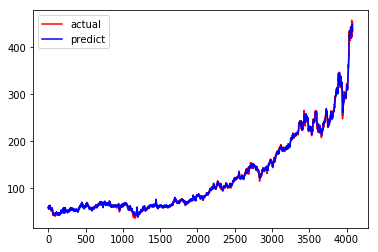

In [276]:

def plot_stock(stock_name,actual,result):

    plt.plot(actual, color='red', label='actual')
    plt.plot(result, color='blue', label='predict')
    plt.legend(loc='best')
    plt.show()
    
df_norm=normalize(df)
X_train, Y_train = buildTrain(df_norm, 30, 1)
result = model.predict(X_train)

result=denormalize(result[:,0],df)
Y_train=denormalize(Y_train[:,0],df)
plot_stock("2330",Y_train,result)